# <center><font color=SeaGreen>Tutoriel génération de texte - Victor Hugo - RNN</font></center>

Dans ce tutoriel, nous utilisons Keras pour créer un réseau de neurones récurrent avec des couches LSTM.
<br>Avec ce RNN entraîné sur des poèmes de Victor Hugo, nous générons du texte.

- [Importer les librairies](#1)
- [Importer et nettoyer les données](#2)
- [Transformer les données](#3)
- [Modélisation](#4)
- [Génération de texte](#5)
- [Enregistrement du modèle + meilleurs poids](#6)
- [Téléchargement du modèle + meilleurs poids](#7)
- [Tentative de réutilisation](#8)

    Pour générer ces textes, nous allons utiliser des réseaux de neurones. 
    Ce sont les algorithmes utilisés derrière la majorité des prouesses récentes en Intelligence Artificielle :
    description automatique d’image, reconnaissance vocale...

    Plus précisément, des réseaux de neurones, nous allons utiliser des architectures récurrentes RNN (Recurrent Neural Networks). 
    Cette classe de réseaux de neurones travaille à partir de données séquentielles brutes, et apprend de la succession des états précédents. 
    
            Nous vous proposons d’introduire les RNN en travaillant sur du texte. 
            Ces modèles sont à la pointe pour capter les dynamiques dans les suites de lettres ou de mots. 
            Ils sont par exemple utilisés en traduction automatique. 
            Nous allons reprendre un cas d’usage classique : la génération de texte

## <a id='1'><font color="SeaGreen"><center>Importer les librairies</center></font></a>

In [1]:
#transformation
import numpy as np
import unidecode
from re import sub

#viz (learning curve)
import matplotlib.pyplot as plt
%matplotlib inline

#modélisation
from keras.models import *
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

#génération de texte
import random

#sauvegarde
from keras.callbacks import ModelCheckpoint
import json

## <a id='2'><font color="SeaGreen"><center>Méthodologie</center></font></a>

Nous avons commencé par suivre le <a href="https://www.youtube.com/watch?v=bpbcKd_mu20&list=PLpEPgC7cUJ4byTM5kGA0Te1jUeNwbSgfd&index=22"> tutoriel en 5 vidéos de Thibault Neveu</a>
 chez qui nous avons récupéré le fichier texte contenant les poèmes de Victor Hugo.
<br>Etant sous Tensorflow, nous n'avons ensuite conservé que le texte et l'indication pour son nettoyage.

Nous avons ensuite bifurqué sur <a href="https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/">un code fait pour Alice in Wonderland</a>.
<br>Celui-ci était également sous Tensorflow, mais nous l'avons modifié pour n'utiliser que Keras.

Après avoir téléchargé les poèmes, nous avons nettoyé le texte pour ne conserver que les caractères nécessaires à l'entraînement de notre modèle.

On a aussi suivi 3 autres tutoriels fait par : <br>
sujet 1 <a href="https://www.youtube.com/watch?v=6ORnRAz3gnA">jeff heaton </a><br>
sujet 2 <a href="https://www.youtube.com/watch?v=RW7mP6BfZuY">max woolf</a><br>
sujet 3 <a href="https://www.youtube.com/watch?v=VAMKuRAh2nc">KGP talkie</a><br>
Le sujet 3 à été abandonné par manque d'information

## <a id='2'><font color="SeaGreen"><center>Importer et nettoyer les données</center></font></a>

In [2]:
#importation du fichier texte avec l'encodage lié, passage en minuscules
raw_text = open("victorhugo.txt", 'r', encoding='utf-8').read().lower() 

raw_text = unidecode.unidecode(raw_text) #suppression des accents
#sub : ca va ciblé le traitement mot par mot
#pattern va chercher toute les valeurs digital et on remplace avec rien
raw_text = sub(pattern=r"\d", repl=r"", string=raw_text) #suppression caractères numériques
#suppression de certains caractères spéciaux (pas tous, sinon utilisation d'une regex)
raw_text = raw_text.replace(">", "")
raw_text = raw_text.replace("<", "")
raw_text = raw_text.replace("!", "")
raw_text = raw_text.replace("?", "")
raw_text = raw_text.replace("-", "")
raw_text = raw_text.replace("$", "")
raw_text = raw_text.replace(";", "")
raw_text = raw_text.replace(":", "")

raw_text = raw_text.strip() #suppression des espaces inutiles
print(raw_text[:1000])

parce que, jargonnant vepres, jeune et vigile,
exploitant dieu qui reve au fond du firmament,
vous avez, au milieu du divin evangile,
ouvert boutique effrontement 

parce que vous feriez prendre a jesus la verge,
cyniques brocanteurs sortis on ne sait d'ou 
parce que vous allez vendant la sainte vierge
dix sous avec miracle, et sans miracle un sou 

parce que vous contez d'effroyables sornettes
qui font des temples saints trembler les vieux piliers 
parce que votre style eblouit les lunettes
des duegnes et des marguilliers 

parce que la soutane est sous vos redingotes,
parce que vous sentez la crasse et non l'oeillet,
parce que vous baclez un journal de bigotes
pense par escobar, ecrit par patouillet 

parce qu'en balayant leurs portes, les concierges
poussent dans le ruisseau ce pamphlet meprise 
parce que vous melez a la cire des cierges
votre affreux suif vertdegrise 

parce qu'a vous tout seuls vous faites une espece
parce qu'enfin, blanchis dehors et noirs dedans,
criant mea culp

## <a id='3'><font color="SeaGreen"><center>Transformer les données</center></font></a>

Nous créons ensuite deux dictionnaires en format clé/valeur = caractère/numéro et numéro/caractère.
<br>Ils nous serviront à encoder/décoder le texte d'entraînement et le texte généré.

In [15]:
print('corpus length:', len(raw_text)) #nb de caractères dans le texte

chars = sorted(list(set(raw_text))) #liste de caractères uniques
print('total chars:', len(chars)) #nb de caractères uniques
char_indices = dict((c, i) for i, c in enumerate(chars)) #création dictionnaire "caractère : numéro"
indices_char = dict((i, c) for i, c in enumerate(chars)) #création dictionnaire "numéro : caractère"
#enregistrement des dictionnaires créés en local
#dumps = exporté
#w = fichier texte
with open("model_rnn_char_indices", "w") as f:
    f.write(json.dumps(char_indices))
with open("model_rnn_indices_char", "w") as f:
    f.write(json.dumps(indices_char))


corpus length: 125813
total chars: 32


Dans la boucle suivante, nous créons les séquences qui, une fois encodées seront utilisées comme input pour notre modèle

#  Découpage du texte en séquences

Pour prédire le prochain caractère, nous devons fournir au RNN une séquence des caractères précédents. 
Afin d’obtenir de nombreux exemples d’apprentissages, nous découpons des séquences dans les discours, en coulissant d’un certain pas entre chaque tranche.

Voici par exemple comment produire des séquences de longueur 40 en coulissant d’un pas de 3 d’une séquence à l’autre :
            Nous avons choisi des séquences de taille 40 afin que l’historique recouvre plusieurs mots. La deuxième dimension de notre matrice d’entrée est donc 40.

Le pas détermine le nombre d’échantillons, c’est à dire la première dimension de la matrice d’entrée. 
Il doit être choisi comme un équilibre entre le nombre d’exemples généré et la diversité des séquences produites.

À l’extrême, un pas de 1 génère toutes les séquences possibles. Cela augmentera le temps d’entraînement, mais sans forcément améliorer les performances. 
En effet, 2 séquences consécutives n’auront que 2 caractères différents, et le réseau verra beaucoup d’exemples redondants. 
Pour notre modèle nous avons choisi un pas de 3 comme représenté sur la figure (longueur de 15 question pratique). 

In [1]:
from IPython.display import Image

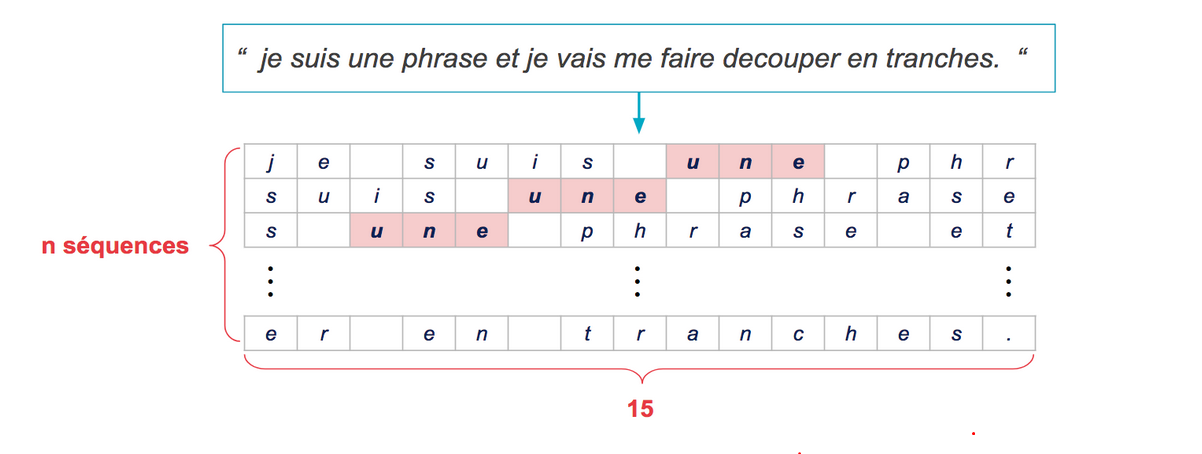

In [5]:
Image("img/séquence.png")

In [ ]:
maxlen = 40  #longueur de 40 caractères
step = 3     #step tous les 3 caractères
#sentences = input
#next_chars = output
sentences = []
next_chars = []

#création de la séquence d'entrée et séquence suivante
for i in range(0, len(raw_text) - maxlen, step):
    sentences.append(raw_text[i: i + maxlen])
    next_chars.append(raw_text[i + maxlen])

print('nb sequences:', len(sentences))
print(sentences)

Ici, les séquences générées précédemment sont encodées sous forme numérique (en x) et boolean (en y)

# Encodage « one-hot » des caractères

    Une fois les séquences de caractères découpées, il faut les encoder dans des vecteurs numériques. 
    On utilise pour cela l’encodage one-hot, où chaque caractère est représenté par un vecteur valant 1 sur une des composantes, et 0 sur les autres. 

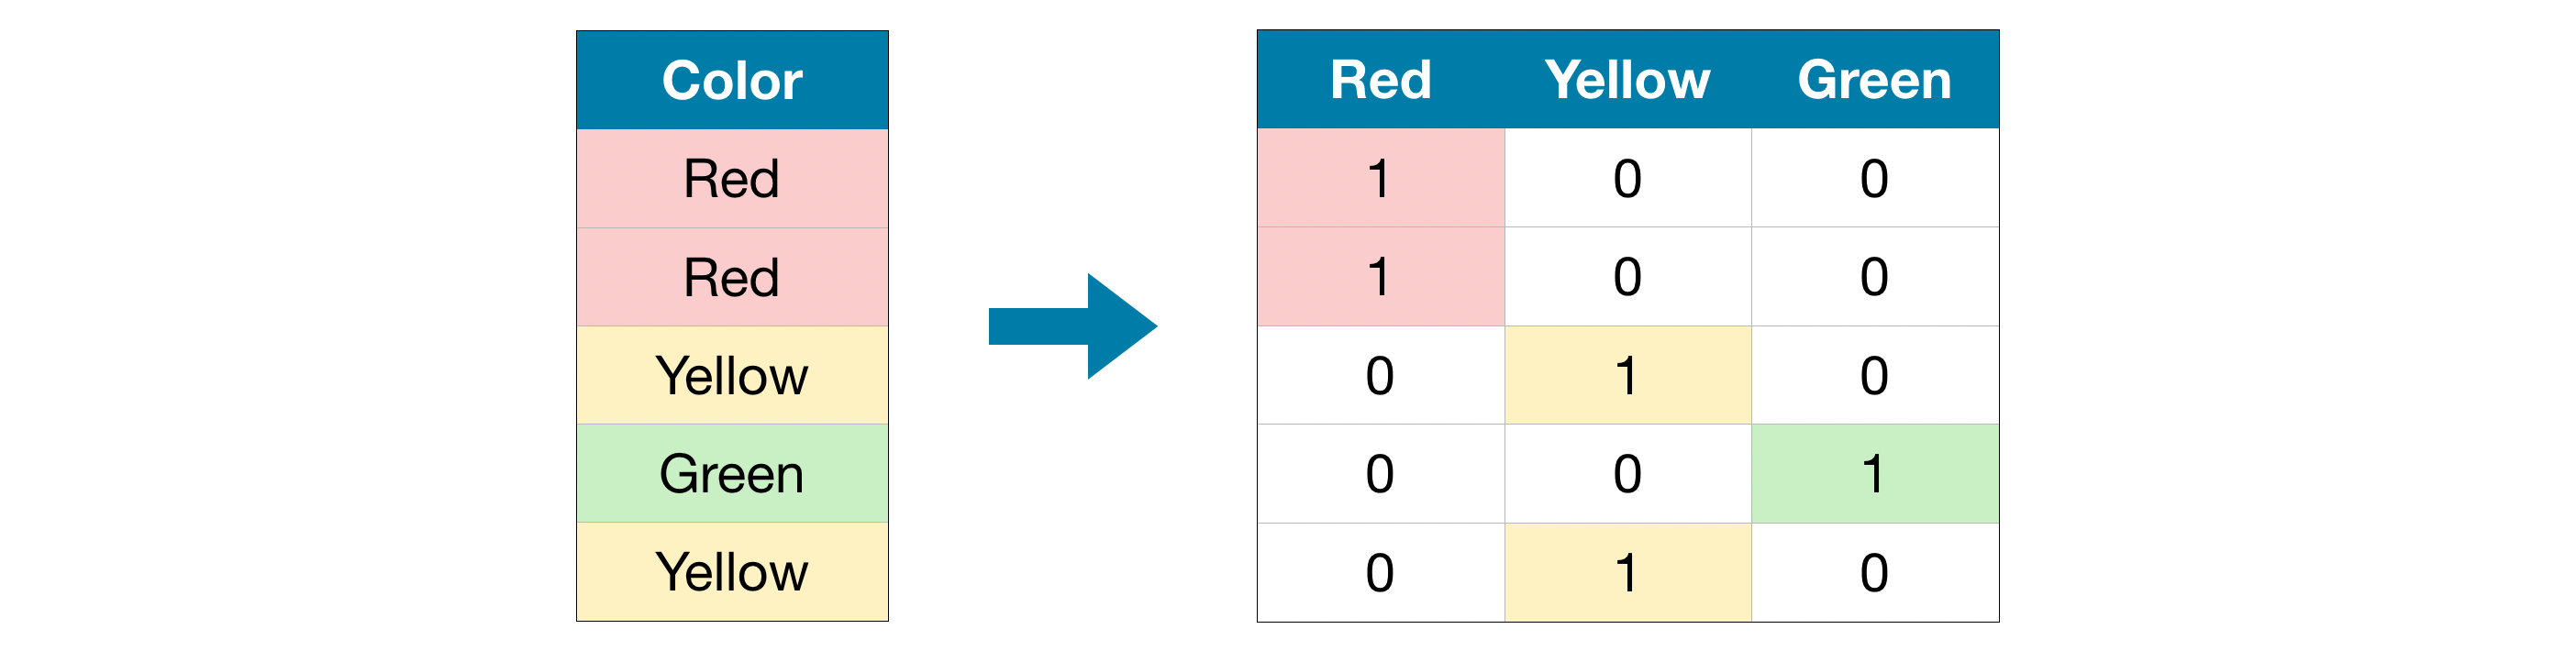

In [10]:
Image("img/one hot.png")

In [5]:
#vectorisation (one hot encoding)
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [6]:
x.shape

(41925, 40, 32)

In [7]:
y.shape

(41925, 32)

# Construire une architecture de réseau récurrent

## <a id='4'><font color="SeaGreen"><center>Modélisation</center></font></a>
Nous paramétrons ensuite le modèle RNN, dans lequel nous introduisons
- une couche d'entrée de dimension (40, 32) (maximum length, nombre de caractères uniques)
- une couche cachée de 128 neurones
- une couche de sortie de 32 neurones (autant de que caractères uniques), avec activation softmax car catégories multiples

Nous le compilons avec une loss correspondant au type de classification recherchée, un optimiser nous permettant d'obtenir les meilleurs résultats, un learning rate de 0.01 (meilleur rate après tests), et accuracy car classification.

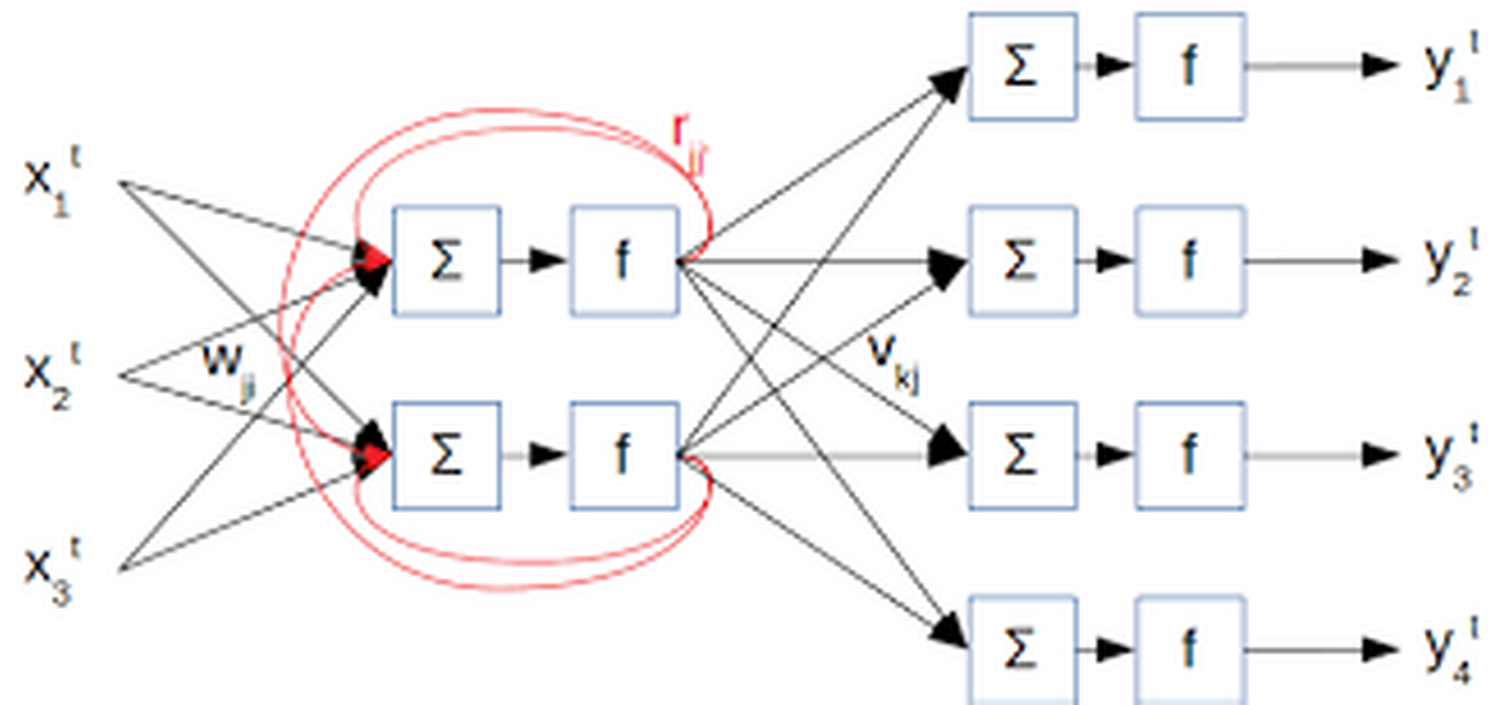

In [14]:
Image("img/RNN multicouches à 3 entrées.png")

Le modèle que nous avons utilisé est un réseau récurrent formé d'une couches RNN. 
La succession de plusieurs couches de RNN augmente la “profondeur” du réseau, et permet d’extraire des relations d’autant plus complexes (moins linéaires) entre les entrées. 

    Un tel modèle s’implémente en quelques lignes avec Keras.        
    On définit un modèle Sequential, sur lequel on ajoute une couche.
    On utilise ici un type particulier de RNN, le Long Short-Term Memory (LSTM). 
    On normalise la prédiction via une fonction softmax pour obtenir une distribution de probabilité.

In [8]:
# build the model: a single LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
Total params: 86,560
Trainable params: 86,560
Non-trainable params: 0
_________________________________________________________________


Le rôle de l’optimizer est déterminant : il va définir comment évolue (apprend) une IA pour s’adapter aux données d’entraînement , qui va encore améliorer les prédictions et la stabilité de vos Intelligences Artificielles. 

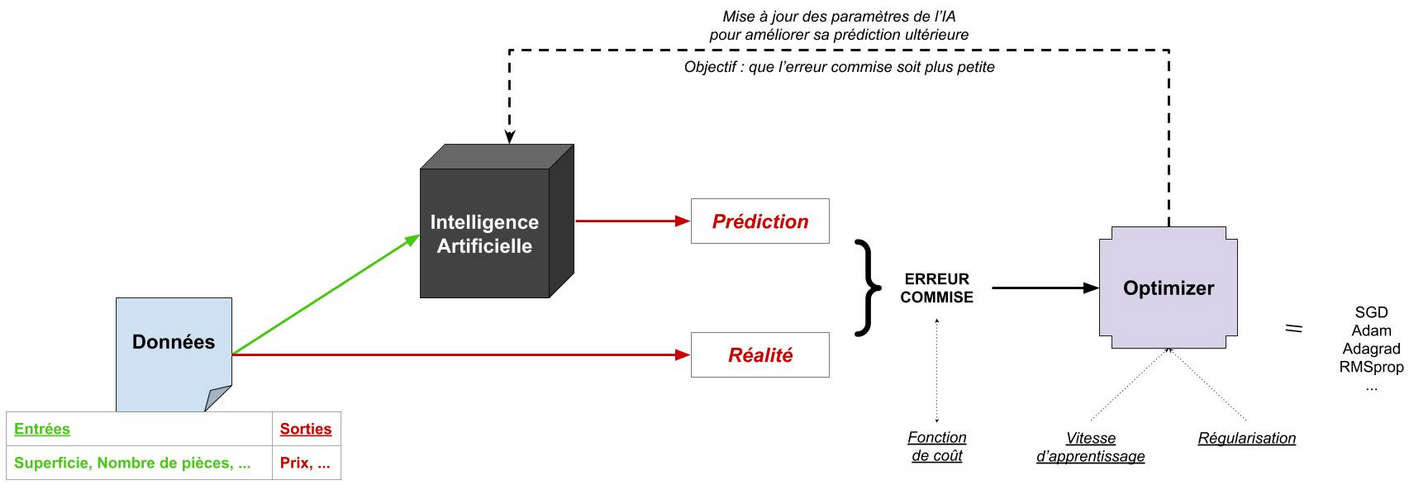

In [16]:
Image("img/RMSprop.png")

Nous créons ici une sauvegarde locale pour conserver les meilleurs poids générés par notre RNN.
<br>La sauvegarde se fait uniquement en cas de diminution de score de loss.

In [9]:
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
callbacks_list = [ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')]
#forme d'enregistrement, selon la loss, exprimé par écriture, uniquement lors d'amélioration, "min" = for loss this should be min

Là, c'est une fonction qui permet d'arrêter l'entrainement lorsque la loss ne s'est pas améliorée après 10 epochs

In [10]:
early_stop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

Nous lançons l'entraînement du modèle avec 256 batchs et dans un premier temps, 100 epochs en guise de test.

# Entraîner un RNN à prédire le prochain caractère

        Notre objectif est de prédire, à partir d’une séquence de 40 caractères consécutifs, le caractère suivant. 
    Il s’agit d’un problème d’apprentissage supervisé de classification : à chaque itération, on fournit au modèle une séquence d’entrée encodée ainsi que le caractère encodé attendu en sortie. 
    Le modèle effectue une prédiction, la compare à la cible attendue, et ajuste ses paramètres (aussi appelés poids du réseau) en cas d’erreur. 
    Nous avons préparé nos données et créé notre modèle, il ne reste  maintenant plus qu’à lancer l’apprentissage. 
    Une ligne suffit pour démarrer cette étape.

Nous avons aussi utilisé google colab pour faire tourner BEAUCOUP vite les modèles

In [12]:
model.fit(x, y, batch_size=256, epochs=3000, validation_split=0.2, callbacks=[callbacks_list, early_stop])

Epoch 1/100
131/132 [============================>.] - ETA: 0s - loss: 2.1307 - accuracy: 0.3297
Epoch 00001: loss improved from 2.43597 to 2.13068, saving model to weights-improvement-01-2.1307-bigger.hdf5
132/132 [==============================] - 21s 156ms/step - loss: 2.1307 - accuracy: 0.3297 - val_loss: 2.3502 - val_accuracy: 0.2518
Epoch 2/100
131/132 [============================>.] - ETA: 0s - loss: 1.9641 - accuracy: 0.3756
Epoch 00002: loss improved from 2.13068 to 1.96424, saving model to weights-improvement-02-1.9642-bigger.hdf5
132/132 [==============================] - 21s 156ms/step - loss: 1.9642 - accuracy: 0.3756 - val_loss: 2.2985 - val_accuracy: 0.2690
Epoch 3/100
131/132 [============================>.] - ETA: 0s - loss: 1.8574 - accuracy: 0.4046
Epoch 00003: loss improved from 1.96424 to 1.85738, saving model to weights-improvement-03-1.8574-bigger.hdf5
132/132 [==============================] - 21s 156ms/step - loss: 1.8574 - accuracy: 0.4046 - val_loss: 1.9329 

Plusieurs meta-paramètres peuvent influencer la qualité de l’entraînement.

    Le nombre d’itérations définit le nombre de passes d’entraînement sur l’ensemble des données. 
    Il a un impact direct sur la durée de l’entraînement. 
    Avec plus d’itération, le modèle apprend mieux la relation entre la séquence d’entrée et la sortie à prédire. 
    Avec trop d’itérations, il y a cependant le risque de sur-apprendre des spécificités des données d’entraînement qui ne se généralisent pas.
    La taille de batch définit la fréquence d’ajustement des poids du réseau. 
    Avec un entraînement par batch, les poids ne sont pas ajustés pour chaque séquence d’entrée, mais pour chaque paquet de séquences de taille fixée. 
    L’utilisation de batchs diminue le nombre de mise à jour et accélère l’apprentissage. 
    Il améliore également la convergence, car on ajuste les poids à partir d’une erreur moyenne sur tout le batch et non d’erreurs individuelles plus volatiles.
    Nous avons choisis différentes optimisation pour l’apprentissage.


Nous présentons l'historique des indicateurs

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['accuracy'])
plt.title('Evolution des indicateurs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

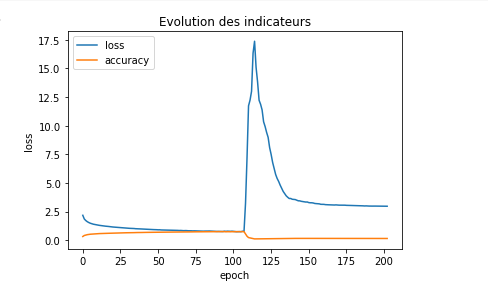

In [7]:
Image("img/BC-32plot.png")

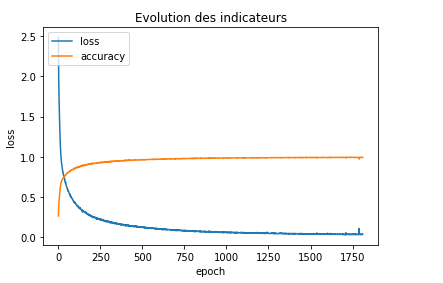

In [8]:
Image("img/BC-256plot.png")

Et la learning curve

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

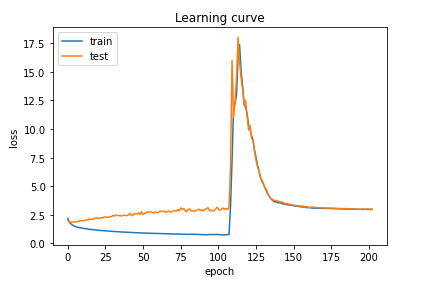

In [9]:
Image("img/BC32-learningcurve.png")

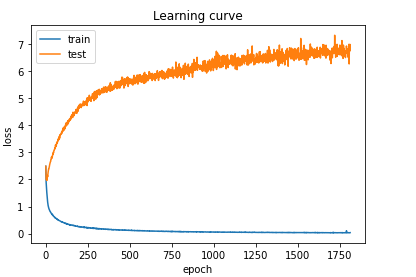

In [10]:
Image("img/BC256-learningcurve.png")

## <a id='5'><font color="SeaGreen"><center>Génération de texte</center></font></a>

# Générer un discours caractère par caractère

    Une fois le modèle entraîné, nous pouvons passer à la génération de texte proprement dite. 
    Notre modèle a été construit pour prédire un caractère à la fois. 
    Comment s’en servir pour générer un texte entier ?

C’est très simple ! Il suffit de donner au modèle une phrase de départ de la bonne taille et de lui demander de prédire un caractère. 
Ce caractère prédit est ensuite concaténé à la phrase initiale et la première lettre de celle-ci est supprimée. 
On se retrouve alors avec une nouvelle séquence de la même taille que la première, avec laquelle on peut à nouveau alimenter le modèle. 
En itérant autant de fois que nécessaire, on obtient finalement un texte de la longueur voulue.

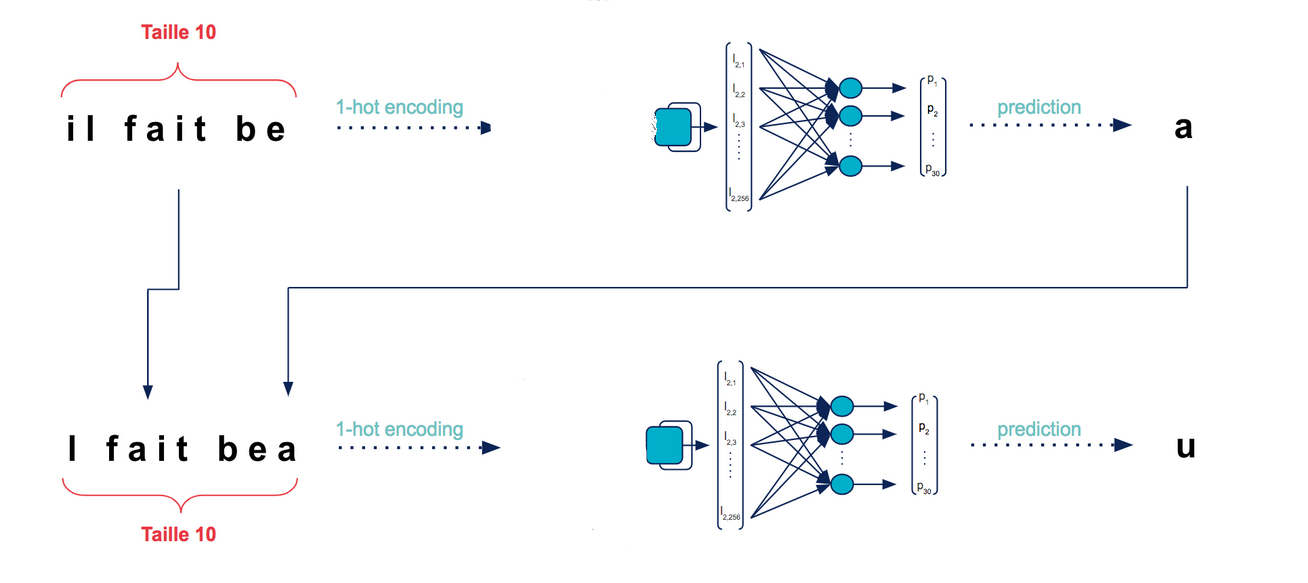

In [15]:
Image("img/Génération de texte.png")

Nous créons une fonction servant à créer un tableau de probabilités qui possède un paramètre appelé température définissant la liberté dont dispose la fonction lors de la création de texte.
<br>Cette fonction nous servira lors de la génération de texte.
<br>Nous nous sommes basés sur <a href="https://www.geeksforgeeks.org/text-generation-using-recurrent-long-short-term-memory-network/">cette aide</a> pour parvenir à nos fins.

In [ ]:
def sample_index(preds, temperature = 1.0): 
    preds = np.asarray(preds).astype('float64') 
    preds = np.log(preds) / temperature 
    exp_preds = np.exp(preds) 
    preds = exp_preds / np.sum(exp_preds) 
    probas = np.random.multinomial(1, preds, 1) 
    return np.argmax(probas) 

Cette nouvelle fonction nous sert à générer le texte, en indiquant le nombre de caractères souhaité et la diversité induite.
<br>Elle se base sur le modèle entraîné précédemment.

In [ ]:
model.save('./MyModel_h5.h5', save_format='h5')
loaded_model_h5 = load_model('./MyModel_h5.h5')

In [ ]:
# loading the saved model
loaded_model.load_weights('weights-improvement-101-0.5557-bigger.hdf5')

In [ ]:
# Defining a utility function to generate new and random raw_text based on the network's learnings 
def generate_raw_text(length, diversity): 
    # Get random starting raw_text 
    start_index = random.randint(0, len(raw_text) - maxlen - 1) 
    generated = '' 
    sentence = raw_text[start_index: start_index + maxlen] 
    generated += sentence 
    for i in range(length): 
            x_pred = np.zeros((1, maxlen, len(chars))) 
            for t, char in enumerate(sentence): 
                x_pred[0, t, char_indices[char]] = 1.
  
            preds = loaded_model.predict(x_pred, verbose = 0)[0] 
            next_index = sample_index(preds, diversity) 
            next_char = indices_char[next_index] 
  
            generated += next_char 
            sentence = sentence[1:] + next_char 
    return generated 
  
print(generate_raw_text(2000, 0.2)) 

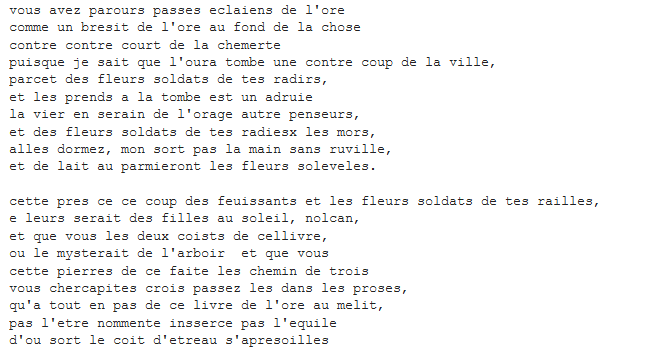

In [3]:
Image("img/BC32-texte.png")

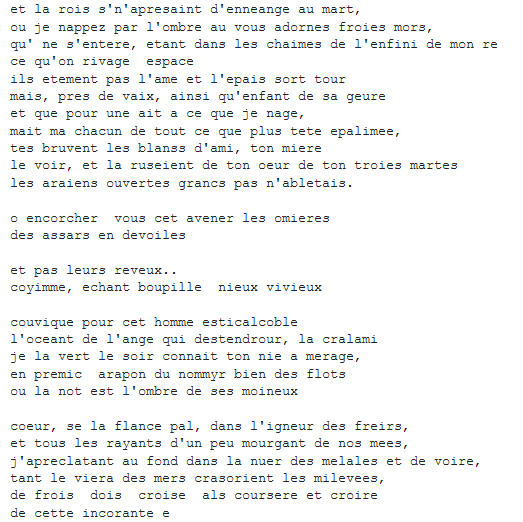

In [4]:
Image("img/BC256-text.png")

In [ ]:
generated_text = generate_raw_text(2000, 0.2)
print(generated_text)
with open('generated_text.txt', 'w') as f:
    f.write(generated_text)

# Jean Jaures peut aller se rhabiller.

## <a id='6'><font color="SeaGreen"><center>Sauvegarde modèle</center></font></a>

In [ ]:
from keras.models import model_from_json
# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('victor_hugo_lstm_256bs.json', 'w') as json_file:
    json_file.write(json_model)

## <a id='6'><font color="SeaGreen"><center>Téléchargement du modèle + meilleur poids</center></font></a>

In [ ]:
model.save("./My_model_tf", save_format="tf")

loaded_model = load_model("./My_model_tf")

loaded_model.load_weights('weights-improvement-51-0.2336-bigger.hdf5')
loaded_model.summary()

# Résultats obtenus

    Rappelons que la génération est faite caractère par caractère, et non mot par mot !
    Autrement dit, en étudiant les 40 derniers caractères et en générant le caractère suivant, notre modèle arrive à reconstruire des mots corrects sans fautes d’orthographe. 
    Il construit des structures grammaticales propres, accorde les adjectifs, conjugue les verbes et reconstruit des parties de phrases qui ont du sens. 
    Tout cela à partir d’un apprentissage du seul texte brut. 
    Ce résultat montre de façon très “parlante” le potentiel des LSTM pour apprendre des dynamiques séquentielles.

# Pour aller plus loin

Nous allons utiliser une autre manière de coder avec un outil keras qui s'apel textgenrnn. Le code s'appuie sur tensorflow et keras

In [ ]:
import keras
import tensorflow

from textgenrnn import textgenrnn
from datetime import datetime 
import os

In [ ]:
file_pat = 'victor.txt'
with open (file_pat, encoding = 'utf-8') as f:
    file_name = f.read()
model_name ='victorhugo'

In [ ]:
import numpy as np

In [ ]:
model_cfg = {
    
    'word_level': False,   # set to True if want to train a word-level model (requires more data and smaller max_length)
    'rnn_size': 128,   # number of LSTM cells of each layer (128/256 recommended)
    'rnn_layers': 3,   # number of LSTM layers (>=2 recommended)
    'rnn_bidirectional': False,   # consider text both forwards and backward, can give a training boost
    'max_length': 30,   # number of tokens to consider before predicting the next (20-40 for characters, 5-10 for words recommended)
                        
    'max_words': 10000,   # maximum number of words to model; the rest will be ignored (word-level model only)
    'dim_embeddings': 100, # ajouter 
}

In [ ]:
train_cfg = {
    'line_delimited': False,   # set to True if each text has its own line in the source file
    'num_epochs': 20,   # set higher to train the model for longer
    'gen_epochs': 5,   # generates sample text from model after given number of epochs,
                        # après tant d'epochs génère du texte, bon pour débugger
    'batch_size' : 256, #v2
    'train_size': 0.8,   # proportion of input data to train on: setting < 1.0 limits model from learning perfectly
    'dropout': 0.0,   # ignore a random proportion of source tokens each epoch, allowing model to generalize better
    'max_gen_length': 300, #nombre de lettres générées V2
    'validation': False,   # If train__size < 1.0, test on holdout dataset; will make overall training slower
    'is_csv': False   # set to True if file is a CSV exported from Excel/BigQuery/pandas
}

In [ ]:
print(file_name)

In [ ]:
from tensorflow.python.keras.backend import set_session

In [ ]:
textgen = textgenrnn(name = model_name)

In [ ]:
train_function = textgen.train_from_fole if train_cfg['line_delimited'] else textgen.train_from_largetext_file(file_pat)
train_function(
        file_path = file_name,
        new_model = True,
        num_epochs = train_cfg['num_epochs'],
        gen_epochs = train_cfg['gen_epochs'],
        batch_size = 1024,
        train_size = train_cfg['train_size'],
        dropout = train_cfg['validation'],
        validation = train_cfg['validation'],
        is_csv = train_cfg['is_csv'],
        rnn_layers = model_cfg['rnn_size'],
        rnn_bidirectional = model_cfg['rnn_bidirectional'],
        max_length = model_cfg['max_length'],
        dim_embeddings = 100,
        word_level = model_cfg['word_level']
            )

Other runtime parameters for train_on_text and train_from_file are:

    num_epochs: Number of epochs to train for (default: 50)
    gen_epochs: Number of epochs to run between generating sample outputs; good for measuring model progress (default: 1)
    batch_size: Batch size for training; may want to increase if running on a GPU for faster training (default: 128)
    train_size: Random proportion of sequence samples to keep: good for controlling overfitting. The rest will be used to train as the validation set. (default: 1.0/all). To disable training on the validation set (for speed), set validation=False.
    dropout: Random number of tokens to ignore each epoch. Good for controlling overfitting/making more resilient against typos, but setting too high will cause network to converge prematurely. (default: 0.0)
    is_csv: Use with train_from_file if the source file is a one-column CSV (e.g. an export from BigQuery or Google Sheets) for proper quote/newline escaping.

temperature peut être définit l'avance 

il faut une loss de moins de 1, selon le créateur de textgenrnn pour avoir quelque chose de crédible 
temperature 0.2 model tries a little of creativity but gets in a loop
temperature 0.5 more creative but still
temperature 1.0 creativity  needs a lot of training

In [ ]:
# pour télécharger 
files.download('{}_weights.hdf5'.format(model_name)) #les poids du modèle
files.download('{}_vocab.json'.format(model_name)) #lettres utilisés par le modèle
files.download('{}_config.json'.format(model_name)) # config we used at the beginning

In [ ]:
from textgenrnn import textgenrnn
textgen =  textgenrnn(weights_path ='victorhugo_weights.hdf5',
                      vocab_path ='victorhugo_vocab.json',
                      config_path ='victorhugo_config.json')

textgen.generate_samples(n=1, max_gen_length =1000)


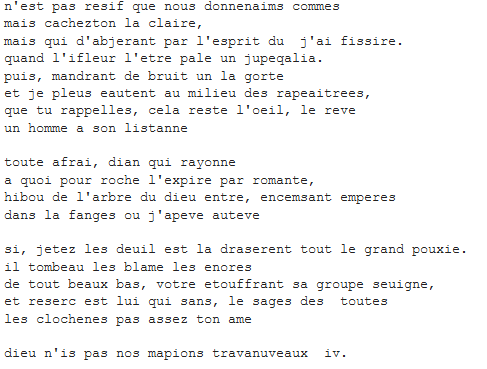

In [13]:
Image("img/txtgnn-BC256.png")

In [ ]:
textgen.generate_to_file('new_victor.txt',n=1, max_gen_length =1000)

## Encore plus loin

Nous allons maintenant utiliser avec les mêmes paramètres un générateur de texte mot par mot cette fois. Nous allons utiliser tensorflow 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import time
sns.set()
from tensorflow.python.framework import ops
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
def get_vocab(file, lower = False):
    with open(file, 'r') as fopen:
        data = fopen.read()
    if lower:
        data = data.lower()
    data = data.split()
    vocab = list(set(data))
    return data, vocab

def embed_to_onehot(data, vocab):
    onehot = np.zeros((len(data), len(vocab)), dtype = np.float32)
    for i in range(len(data)):
        onehot[i, vocab.index(data[i])] = 1.0
    return onehot

In [ ]:
text, text_vocab = get_vocab('victor.txt', lower = True)

In [ ]:
f = open('victor.txt', 'w')
f.write(raw_text)
f.close()

In [ ]:
learning_rate = 0.01
batch_size = 16
sequence_length = 32
epoch = 3000
num_layers = 2
size_layer = 256
possible_batch_id = range(len(text) - sequence_length - 1)

In [ ]:
class Model:
    def __init__(self, num_layers, size_layer, dimension, sequence_length, learning_rate):
        def lstm_cell():
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, sequence_length, state_is_tuple = False)
        self.rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in range(num_layers)], 
                                                     state_is_tuple = False)
        self.X = tf.placeholder(tf.float32, (None, None, dimension))
        self.Y = tf.placeholder(tf.float32, (None, None, dimension))
        self.hidden_layer = tf.placeholder(tf.float32, (None, num_layers * 2 * size_layer))
        self.outputs, self.last_state = tf.nn.dynamic_rnn(self.rnn_cells, self.X, 
                                                          initial_state = self.hidden_layer, 
                                                          dtype = tf.float32)
        rnn_W = tf.Variable(tf.random_normal((size_layer, dimension)))
        rnn_B = tf.Variable(tf.random_normal([dimension]))
        self.logits = tf.matmul(tf.reshape(self.outputs, [-1, size_layer]), rnn_W) + rnn_B
        y_batch_long = tf.reshape(self.Y, [-1, dimension])
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, 
                                                                           labels = y_batch_long))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(self.cost)
        self.correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(y_batch_long, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        seq_shape = tf.shape(self.outputs)
        self.final_outputs = tf.reshape(tf.nn.softmax(self.logits), 
                                        (seq_shape[0], seq_shape[1], 
                                         dimension))

In [ ]:
ops.reset_default_graph()
sess=tf.compat.v1.InteractiveSession()
model = Model(num_layers, size_layer, len(text_vocab), sequence_length, learning_rate)
sess.run(tf.global_variables_initializer())

In [ ]:
def train_random_sequence():
    LOST, ACCURACY = [], []
    pbar = tqdm(range(epoch), desc = 'epoch')
    for i in pbar:
        last_time = time.time()
        init_value = np.zeros((batch_size, num_layers * 2 * size_layer))
        batch_x = np.zeros((batch_size, sequence_length, len(text_vocab)))
        batch_y = np.zeros((batch_size, sequence_length, len(text_vocab)))
        batch_id = random.sample(possible_batch_id, batch_size)
        for n in range(sequence_length):
            id1 = embed_to_onehot([text[k + n] for k in batch_id], text_vocab)
            id2 = embed_to_onehot([text[k + n + 1] for k in batch_id], text_vocab)
            batch_x[:,n,:] = id1
            batch_y[:,n,:] = id2
        last_state, _, loss = sess.run([model.last_state, model.optimizer, model.cost], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.hidden_layer: init_value})
        accuracy = sess.run(model.accuracy, feed_dict = {model.X: batch_x, 
                                                         model.Y: batch_y, 
                                                         model.hidden_layer: init_value})
        ACCURACY.append(accuracy); LOST.append(loss)
        init_value = last_state
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    return LOST, ACCURACY

In [ ]:
LOST, ACCURACY = train_random_sequence()

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(LOST))
plt.plot(EPOCH, LOST)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()

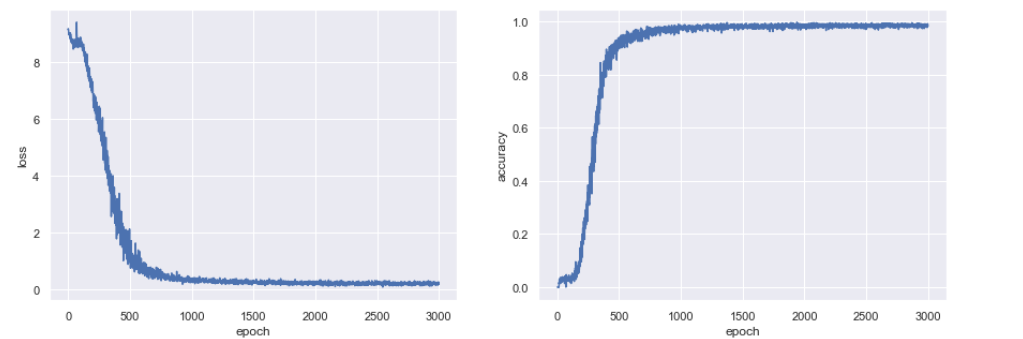

In [11]:
Image("img/loss-acc-MparM.png")

In [ ]:
split_text = text
selected_index = np.random.randint(0, len(split_text) - 5)
tag = split_text[selected_index:selected_index + 5]
print(tag)

In [ ]:
def generate_based_sequence(length_sentence, argmax = False):
    sentence_generated = tag[:]
    onehot = embed_to_onehot(tag, text_vocab)
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for i in range(len(tag)):
        batch_x = np.zeros((1, 1, len(text_vocab)))
        batch_x[:, 0, :] = onehot[i, :]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    for i in range(length_sentence):
        if argmax:
            index = np.argmax(prob[0][0])
        else:
            index = np.random.choice(range(len(text_vocab)), p = prob[0][0])
        element = [text_vocab[index]]
        sentence_generated += element
        onehot = embed_to_onehot(element, text_vocab)
        batch_x = np.zeros((1, 1, len(text_vocab)))
        batch_x[:, 0, :] = onehot[0, :]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    return ' '.join(sentence_generated)


In [ ]:
print(generate_based_sequence(100,True))

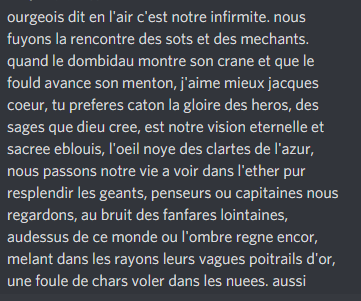

In [14]:
Image("img/MparM32.png")

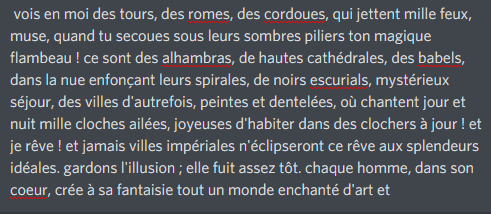

In [2]:
Image("img/MparM256.png")

In [ ]:
print(generate_based_sequence(100,False))

## Vers l'infini et l'au dela

Nous avons pu voir qu'un des modèles les plus performant utilisait la technologie gtp-2 avec bert.<br>
Que beaucoup utilisait l'optimizer Ranger (composé de RAdam et LookAhead)<br>
On peut aussi utiliser la technologie gtp-2 et bert pour la traduction de texte